In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
%matplotlib notebook

In [4]:
def generate_torus(n, m):
    # TODO: Return T_{nm}, the n x m torus grid.
    #       Each edge should have a color attribute.
    #       Color the vertical edges red and the horizontal blue.
    
    
    # This will just be the graph stored as a matrix
    # for convenience
    M = []
    T = nx.Graph()

    #Adding Nodes
    for i in range(n):
        row = []
        for j in range(m):
            T.add_node(i * m + j, label= "{}".format(i * m + j))
            row.append(i * m + j)
        M.append(row)

    #Adding Edges
    for i in range(n):
        for j in range(m):
            adj_nodes = {}
            element = i * m + j
            if not T.has_edge(element, M[i-1][j]):
                adj_nodes[(element, M[i-1][j])] = 'red'

            if not T.has_edge(element, M[i][j-1]):
                adj_nodes[(element, M[i][j-1])] = 'blue'

            if i+1 >= n and not T.has_edge(element, M[0][j]): 
                    adj_nodes[(element, M[0][j])] = 'red' 

            if i+1 < n and not T.has_edge(element, M[i+1][j]):
                adj_nodes[(element, M[i+1][j])] = 'red'

            if j+1 >= m and not T.has_edge(element, M[i][0]):
                adj_nodes[(element, M[i][0])] = 'blue'

            if j+1 < m and not T.has_edge(element, M[i][j+1]):
                adj_nodes[(element, M[i][j+1])] = 'blue'

            for edge, color in adj_nodes.items():
                T.add_edge(edge[0], edge[1], edge_color=color)

    return T


# Heat Equation and Spectral Embedding

In class we saw how following the dynamics of the Heat Equation will yield the vector $\mathbf{v} = \arg \min_{\mathbf{x} \perp 1} \frac{\mathbf{x}^T \mathbf{L}_G \mathbf{x}}{\mathbf{x}^T \mathbf{D}_G \mathbf{x}}$.

In this section you will implement the dynamic $\mathbf{x}_{t + 1} = \mathbf{x}_t - \frac{1}{2}\mathbf{D}_G^{-1} \mathbf{L}_G \mathbf{x}_t$ to approximate the second eigenvalue. Your goal is to approximate the second eigenvector by following this evolution.

### Heat Evolution

Complete the following function which takes in a graph $G$, an initial $\mathbf{x}_0 \in \mathbb{R}^{n \times d}$ and a target bound $\epsilon$ for the Dirichlet energy $\mathcal{U}(\mathbf{x}) = \|\mathbf{x} - \bar{x} \mathbf{1}\|_{\mathbf{D}_G}$ and returns the iterates $\mathbf{X} \in \mathbb{R}^{T \times n \times d}$.

In [5]:
from typing import Tuple

def Dirichlet_energy(x: np.array, xbar: float, deg_mat: np.ndarray) -> float:
    """
    Calculates the Dirichlet energy for a given state x and average xbar. 
    Also needs the Degree matrix from graph G
    
    Parameters
    ----------
        x: np.array
           The state vector.
        xbar: float
           The float value to which the system will converge.
        deg_mat: np.ndarray
            The degree matrix of the graph
    
    Returns
    -------
        Dirichlet : float
            The ``Energy" of the system. I.e. how har we are from uniform distribution
    """
    
    #Construct xbar_vec as column vector with size of the state vector
    xbar_vec = xbar * np.ones((1,len(x)))

    #check if state vector is a row vector
    if x.shape != xbar_vec.shape:
        x= x.T
        
    #Difference the state vector is from average element wise
    state_difference = (x - xbar_vec)[0]
    
    
    Dirichlet = np.dot(state_difference, np.matmul(deg_mat, state_difference.T))
    Dirichlet *= 0.5
    
    return float(Dirichlet)

def calculate_xbars(G: nx.Graph, x_0: np.ndarray) -> np.array:
    """
    Calculates the average state for all initial conditions.
    
    Parameters
    ----------
    G: nx.Graph
        The Graph. Will calcualte the volume and degree matrix from it
    x_0 : np.array
        The array of initial conditions
    """
    deg_mat =  np.diag(np.array([node[1] for node in list(G.degree())]))
    vol = nx.volume(G, G.nodes())
    
    if x_0.ndim > 1:
        xbars = np.zeros((1, x_0.shape[1]))
    else:
        xbars = np.zeros((1, 1))

    #Check to see if x_0's a row vector
    if max(x_0.shape) != x_0.shape[1]:
        x_0 = x_0.T
        
    i = 0
    for ele in xbars:
        if x_0.ndim != 1:
            for init_condit in x_0:
                if(max(x_0.shape)) == x_0.shape[1]:
                    temp = float((1/vol) * np.dot(np.ones((1, len(G.nodes()))) @ deg_mat, x_0[i, :]))
                else:
                    temp = float((1/vol) * np.dot(np.ones((1, len(G.nodes()))) @ deg_mat, x_0[:, i]))
                ele[i] = temp
                i+=1
        else:
            temp = float((1/vol) * np.dot(np.ones((1, len(G.nodes()))) @ deg_mat, x_0))
            ele[i] = temp

    return xbars[0]


def heat_diffusion(G: nx.Graph, x_0: np.ndarray, epsilon: float=1e-6) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Heat Diffusion
    
    Given a graph `G` and an initial `x_0` runs heat diffusion until $\mathcal{U}(\mathbf{x}) < \epsilon$.
    
    Parameters
    ----------
        G : nx.Graph
            Graph to run heat diffusion on.
        x_0 : np.ndarray
            Initial heat distribution x_0. Should be n x d array. d might be 1.
        epsilon : float
            Stopping criterion is the Dirichlet energy of the heat distribution to be less than epsilon.
    
    Returns
    -------
        x : np.ndarray
            The T x n x d evolution of x_0.
        y : np.ndarray
            Flow going through each edge. Should be T x m x d
        fx: np.ndarray
            The value of U(x(t)) at each time t.
    """
    n = nx.number_of_nodes(G)
    m = nx.number_of_edges(G)
    assert x_0.shape[0] == n, "x_0 does not have the right shape."
    #d = x_0.shape[1]
    
    
    #Calculating degree matrix and its inverse
    deg_mat =  np.diag(np.array([node[1] for node in list(G.degree())]))
    deg_inv_mat = np.linalg.inv(deg_mat)

    #Calculating Adjacency matrix and the Laplacian
    adj_mat = nx.adjacency_matrix(G)
    Laplacian = deg_mat - adj_mat
    
    #No way we'll need more than 100 steps
    max_num_steps = 100

    
    #Storing the number of initial conditions
    number_of_init_condit = x_0.shape[0]

    #Need to check the number of initial conditions we have
    if x_0.ndim == 1:
        number_of_nodes = len(x_0) 
    else:
        number_of_nodes = nx.number_of_nodes(G)

    #Making the array that will hold the state at all timesteps
    xresult_arr = np.zeros((max_num_steps+1, number_of_nodes, number_of_init_condit))

    #Flow will have same shape as xresult_arr
    yresult_arr = np.zeros((max_num_steps+1, number_of_nodes, number_of_init_condit))

    #Making array to hold the Dirichlet energy for each step. Will be T x d
    diri_arr = np.zeros((max_num_steps+1, number_of_init_condit))

    it = 0
    max_iter = 0
    
    #Calculating xbars
    xbars = calculate_xbars(G, x_0)

    #Calculate Dinverse and laplacian out of loop
    M = np.matmul(deg_inv_mat, Laplacian)
        
    #If we have only one set of initial conditions, pack it.
    if x_0.ndim == 1:
        x_0 = np.array([x_0])
        
    #Want to work with row vectors
    if x_0.shape[1] != Laplacian.shape[0]:
        x_0 = x_0.T
    
    #Inside the while loop
    for init_condit in x_0:

        #make three arrays to hold state vector, flow, and Dirichlet energy
        rows, cols = (1, len(init_condit))
        xarr = [[0 for i in range(cols)] for j in range(rows)]
        yarr = [[0 for i in range(cols)] for j in range(rows)]
        darr = []

        #Change first row to initial conditions
        xarr[0] = init_condit
       
        thres = 0
        #Iterate state until threshold
        while (Dirichlet_energy(xarr[-1], xbars[it], deg_mat) > epsilon and thres < max_num_steps):

            next_iter = xarr[-1] - 0.5 * np.matmul(M, xarr[-1])        
            
            yarr.append(xarr[-1] - next_iter)
            darr.append(Dirichlet_energy(xarr[-1], xbars[it], deg_mat))
            
            #This needs to be appended last
            xarr.append(next_iter)

            thres +=1
            
        #now have array for this init condit, append these to existing arrays
        row_iter = 0
        diri_arr[:len(darr), it] = darr
        for rowx, rowy in zip(xarr, yarr):
            xresult_arr[row_iter, :len(rowx), it] = rowx
            yresult_arr[row_iter, :len(rowy), it] = rowy
            row_iter +=1

        max_iter = max(max_iter, row_iter)
        
        it+=1
        #Clear the array for reuse
        xarr.clear()
        yarr.clear()
        darr.clear()
        row_iter = 0

    #Resizing output arrays to reasonable sizes
    diri_arr = diri_arr[:max_iter, :it]
    xresult_arr = xresult_arr[:max_iter+1, :, :]
    yresult_arr = yresult_arr[1:max_iter+1, :, :]
        
    return xresult_arr, yresult_arr, diri_arr

#x0 = np.random.rand(len(les_miserables), 2)
#x, y, fx = heat_diffusion(les_miserables, x0)

In [6]:
les_miserables = nx.les_miserables_graph()
x0 = np.random.rand(len(les_miserables), 1)
x1, y1, fx1 = heat_diffusion(les_miserables, x0)

T = generate_torus(10, 10)
x01 = np.random.rand(len(T), 2)
x, y, fx = heat_diffusion(T, x01)

<IPython.core.display.Javascript object>


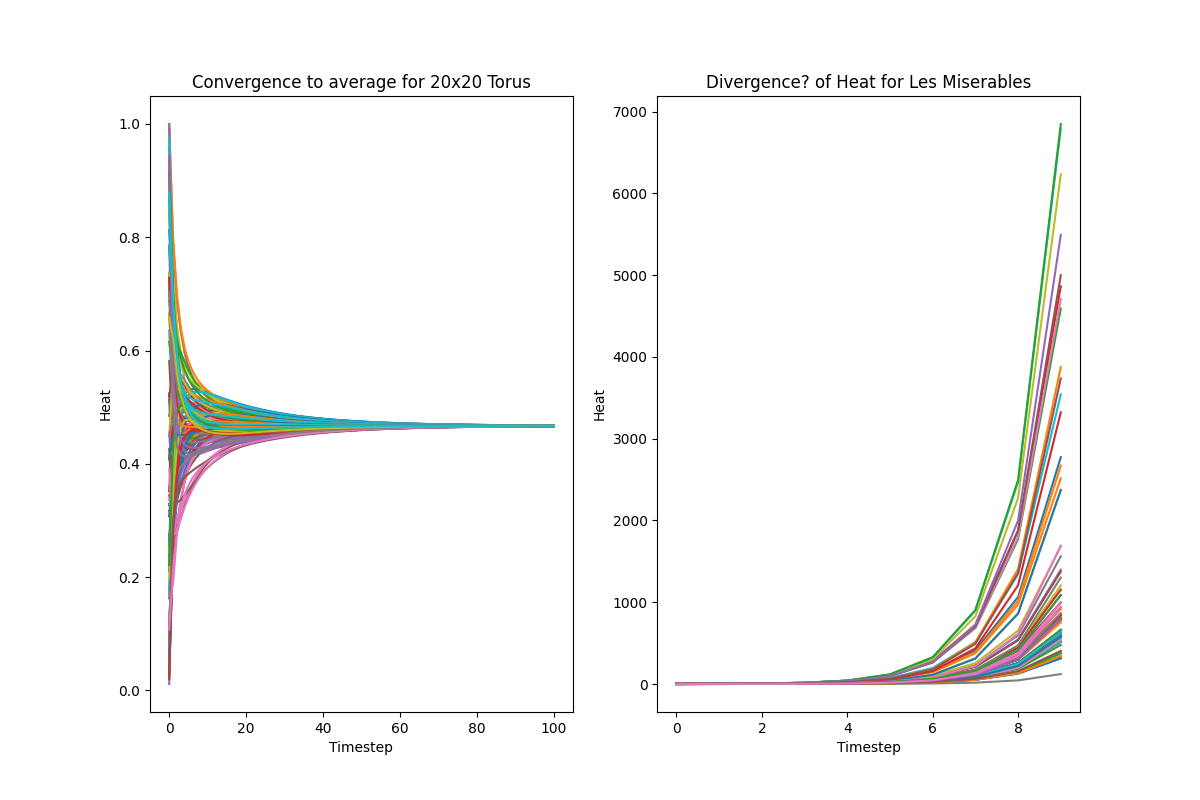

Text(0, 0.5, 'Heat')

In [7]:
plt.subplots(1, 2, figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(x[:, :, 0])
plt.title("Convergence to average for 20x20 Torus")
plt.xlabel("Timestep")
plt.ylabel("Heat")

plt.subplot(1, 2, 2)
plt.plot(x1[:10, :, 0])
plt.title("Divergence? of Heat for Les Miserables")
plt.xlabel("Timestep")
plt.ylabel("Heat")


In [8]:
fx[:, 0]

array([1.92155883e+01, 4.90260044e+00, 2.06111897e+00, 1.13801056e+00,
       7.48387876e-01, 5.45948735e-01, 4.23600636e-01, 3.41777710e-01,
       2.83219862e-01, 2.39260054e-01, 2.05055144e-01, 1.77682606e-01,
       1.55278261e-01, 1.36602029e-01, 1.20800547e-01, 1.07269211e-01,
       9.55682618e-02, 8.53699748e-02, 7.64245025e-02, 6.85372965e-02,
       6.15538900e-02, 5.53494568e-02, 4.98215254e-02, 4.48848076e-02,
       4.04674636e-02, 3.65083596e-02, 3.29550175e-02, 2.97620565e-02,
       2.68899880e-02, 2.43042696e-02, 2.19745508e-02, 1.98740627e-02,
       1.79791192e-02, 1.62687035e-02, 1.47241226e-02, 1.33287156e-02,
       1.20676057e-02, 1.09274880e-02, 9.89644643e-03, 8.96379576e-03,
       8.11994348e-03, 7.35626963e-03, 6.66502134e-03, 6.03922000e-03,
       5.47257948e-03, 4.95943375e-03, 4.49467273e-03, 4.07368536e-03,
       3.69230887e-03, 3.34678361e-03, 3.03371270e-03, 2.75002594e-03,
       2.49294756e-03, 2.25996720e-03, 2.04881403e-03, 1.85743334e-03,
      

In [9]:
con = []
for iterate in x[:, :, 0]:
    con.append( 2*(iterate - x[-1, 0, 0])**2)

con[0].sum() / fx[0, 0]

1.000000000247766

In [10]:
def get_color_array(x: np.ndarray) -> np.ndarray:
    """
    Calculates the coloring for each node for all iterations. 
    This is assuming our graph is the torus, so each node has degree 4
    
    Parameters
    ----------
    x: np.ndarray
        The array of size T x n. Only give it one set of initial conditions 
    
    Returns
    -------
    colors: np.ndarray
        The color array for each iteration and node given in rgba
    """
    #Taking the last iteration to be roughly equal to xbar to avoid 
    #    recalcualting it
    #    Contribution of each node to the Dirichelt energy at iteration
    con = []
    for iterate in x[:, :]:
        con.append(2*(iterate - x[-1, 0])**2)

    #normalizing to max contribution
    i = 0
    for iterate in con:
        maxcon = max(iterate)
        iterate /= maxcon
        con[i] = iterate
        i+=1

    colors = []
    for iterate in con:
        temp = []
        for val in iterate:
            temp.append(cm.hot(min(val**0.5, 0.9)))
        colors.append(temp)
        
    return colors

def get_nodesize(x: np.array, scale: float) -> np.array:
    """
    Simple function to calcualte the size of each node
    
    Paramters
    ---------
    x: np.array
        The nodes and their values
    scale: float
        Adjustable scaling for node sizes
    
    Returns
    -------
    The scaled nodes
    """
    return scale*x

def get_linewidth(y: np.array, scale: float) -> np.array:
    """
    Simple function to calcualte the size of each node
    
    Paramters
    ---------
    y: np.array
        The edges and their values
    scale: float
        Adjustable scaling for line width
    
    Returns
    -------
    The scaled edges
    """
    linewidth = []
    for val in y:
        linewidth.append(scale*abs(val))
        
    return linewidth

<IPython.core.display.Javascript object>


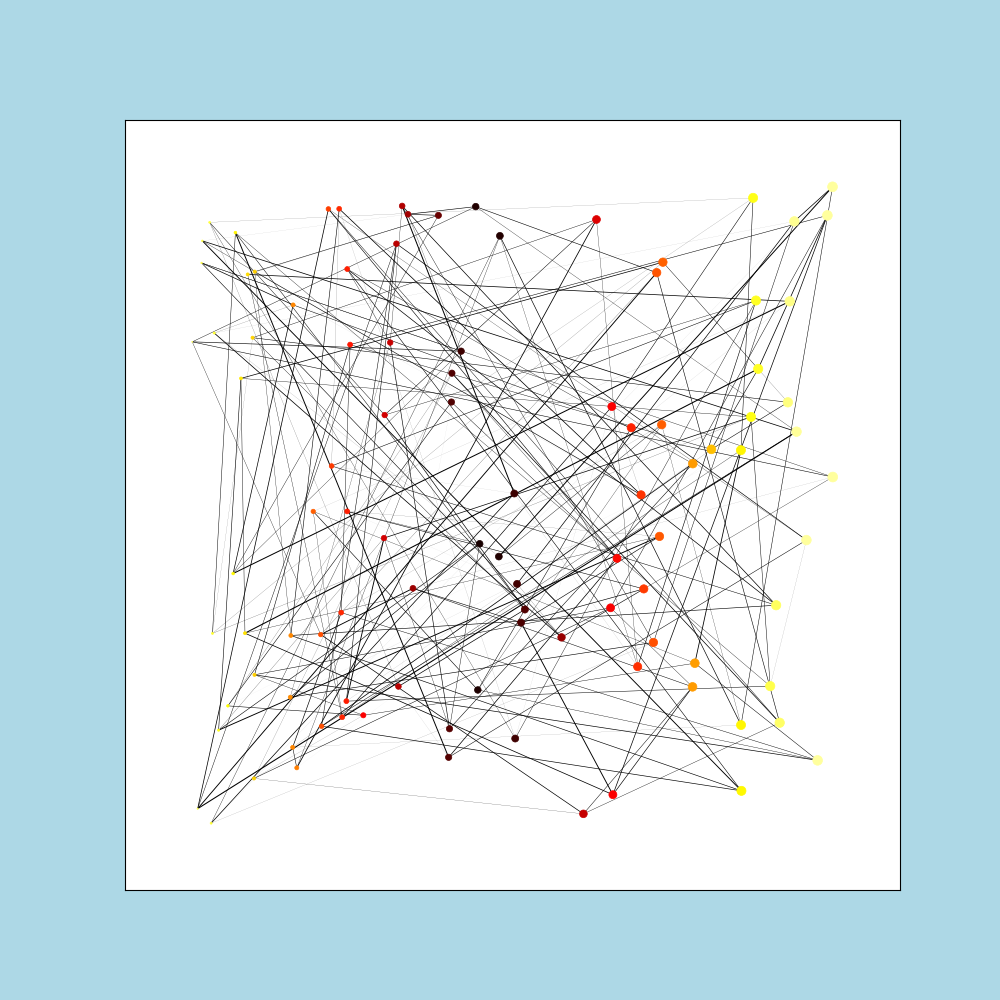

In [11]:
pos = {v: x01[i] for i, v in enumerate(T.nodes)}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
plt.style.use('ggplot')
fig.set_facecolor('lightblue')
color_arr = get_color_array(x[:, :, 0])
ax= nx.draw_networkx_nodes(T, pos = pos, node_size=get_nodesize(x[0, :, 0], 50), node_color=color_arr[0])
ax =nx.draw_networkx_edges(T, pos=pos, width = get_linewidth(y[0, :, 0], 2))
plt.show()

<IPython.core.display.Javascript object>


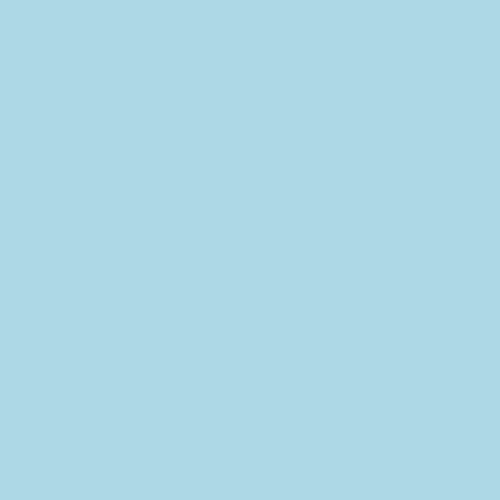

In [13]:
pos = {v: x01[i] for i, v in enumerate(T.nodes)}
fig = plt.figure()
fig.set_size_inches((5.0, 5.0))
plt.style.use('ggplot')
fig.set_facecolor('lightblue')
color_arr = get_color_array(x[:, :, 0])

def animate(frame, it):
    node_collection = nx.draw_networkx_nodes(T, pos = pos, node_size=get_nodesize(x[frame, :, 0], 50), node_color=color_arr[frame])
    edge_collection = nx.draw_networkx_edges(T, pos=pos, width = get_linewidth(y[frame, :, 0], 2))
    
    return node_collection, edge_collection

t, n, d = x.shape

ani = FuncAnimation(fig, func=animate , frames=t, interval=40, repeat=True, repeat_delay=1500)
plt.show()

<IPython.core.display.Javascript object>


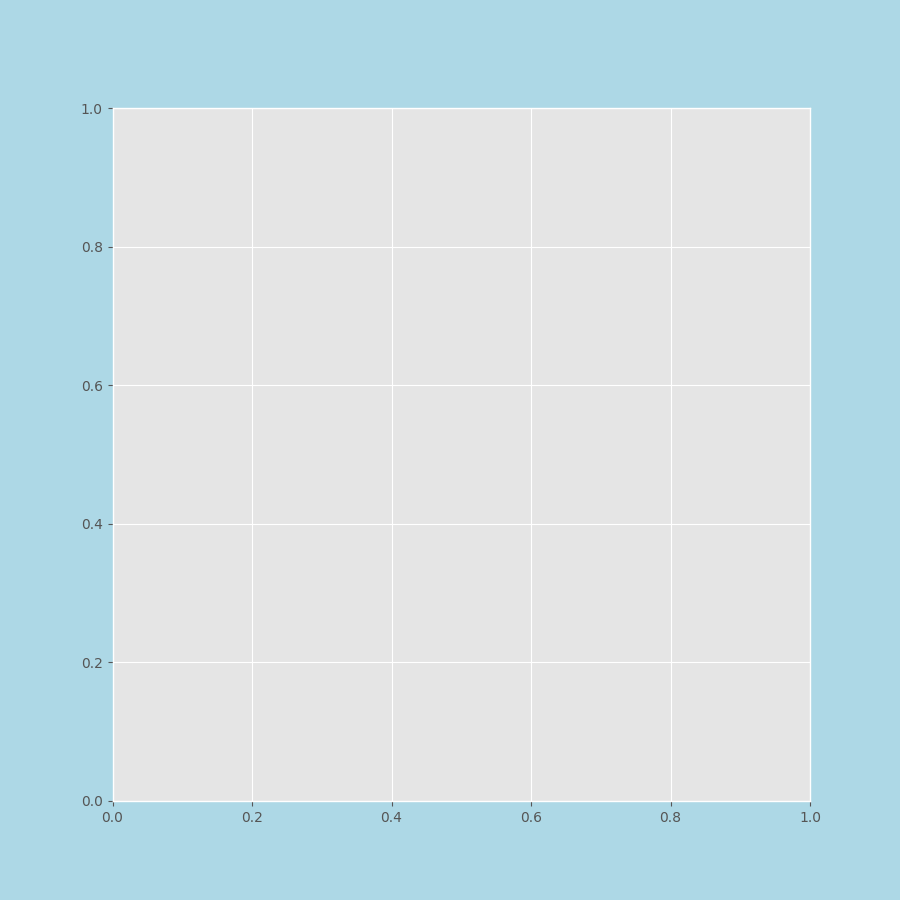

In [12]:
def create_animation(T: nx.Graph, x: np.ndarray, y: np.ndarray, t: int, i: int):
    """
    Hopefully creates the animation
    
    Parameters
    ----------
    T :nx.Graph
        The graph provided
    
    x: np.ndarray
        The T x n x d array for which stores T iterations of heat flow on n nodes 
        run on d inital conditions.
        
    y: np.ndarray
        The T x n x d array which holds the energy flow along each edge 
    
    t: int
        The total frames for the animation. 
        Should also be the same number of iterations of the heat diffusion
    
    i: int
        The inital condition index in x
    """
    fig, ax = plt.subplots(figsize=(9, 9))
    plt.style.use('ggplot')
    fig.set_facecolor('lightblue')
    color_arr = get_color_array(x[:, :, i])
    pos = {v: x[0, j, i] for j, v in enumerate(T.nodes)}


    def animate(frame, i, x, y, color_arr):
        pos = {v: x[frame, j, i] for j, v in enumerate(T.nodes)}
        node_collection = ax.draw_networkx_nodes(T, pos=pos, node_size=get_nodesize(x[frame, :, i], 50), node_color=color_arr[frame])
        edge_collection = ax.draw_networkx_edges(T, pos=pos, width=get_linewidth(y[frame, :, i], 2))

        
        return node_collection, edge_collection


    ani = FuncAnimation(fig, func=animate, fargs = (i, x, y, color_arr), frames=t, interval=t, repeat=True)

    plt.show()
    
    return ani

t, n, d = x.shape   

ani = create_animation(T, x ,y, t, 0)

<IPython.core.display.Javascript object>


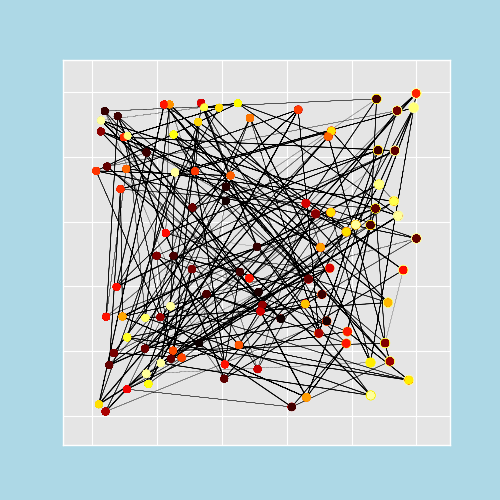

In [19]:
pos = {v: x01[i] for i, v in enumerate(T.nodes)}
fig = plt.figure()
fig.set_size_inches((5.0, 5.0))
plt.style.use('ggplot')
fig.set_facecolor('lightblue')
color_arr = get_color_array(x[:, :, 0])

def animate(frame):
    node_collection = nx.draw_networkx_nodes(T, pos = pos, node_size=get_nodesize(x[frame, :, 0], 50), node_color=color_arr[frame])
    edge_collection = nx.draw_networkx_edges(T, pos=pos, width = get_linewidth(y[frame, :, 0], 2))
    
    return node_collection, edge_collection

t, n, d = x.shape

ani = FuncAnimation(fig, func=animate , frames=t, interval=40, repeat=True, repeat_delay=1500)
plt.show()